In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

np.random.seed(seed=0)

In [2]:
# ==============================================================
# LIF（Leaky Integrate-and-Fire）ニューロンモデルの初期設定
# --------------------------------------------------------------
# このコードでは、単一ニューロンの膜電位をシミュレートする。
# 膜電位は入力電流によって上昇し、閾値を超えるとスパイク発火し、
# その後リセット電位に戻って再び充電を始める。
# ==============================================================

dt = 5e-5  # 時間刻み幅 [s]（=0.05 ms）
T = 0.4  # シミュレーション全体の時間 [s]
nt = round(T / dt)  # シミュレーションの総ステップ数（= T / dt）

# ==============================================================
# ニューロンの生理学的パラメータ
# ==============================================================

tref = 2e-3  # 不応期 [s]：スパイク後に再発火できない時間
tc_m = 1e-2  # 膜時定数 [s]：膜電位の充電・放電速度を決める
vrest = -60  # 静止膜電位 [mV]：刺激がないときの膜電位
vreset = -65  # リセット電位 [mV]：スパイク後に戻る電位
vthr = -40  # 閾値電位 [mV]：発火のしきい値
vpeak = 30  # ピーク電位 [mV]：スパイクの最大値

# ==============================================================
# 時間軸と入力電流の定義
# --------------------------------------------------------------
# t: ミリ秒単位の時間軸
# I: 一定時間だけ加えられる矩形入力電流
#    50 ms 〜 350 ms の間に +21 の刺激が加わる
# ==============================================================
t = np.arange(nt) * dt * 1e3  # 時間軸 [ms]
I = 21 * (t > 50) - 21 * (t > 350)  # 入力電流 [mV]（閾値超過を誘発）

# ==============================================================
# シミュレーション用変数の初期化
# --------------------------------------------------------------
# v: 現在の膜電位
# tlast: 最後にスパイクした時刻
# v_arr: 各時刻の膜電位を記録する配列
# ==============================================================
v = vreset  # 初期膜電位 [mV]
tlast = 0  # 最後のスパイク発生時刻を記録
v_arr = np.zeros(nt)  # 膜電位を時間ごとに保存

In [3]:
# ==============================================================
# LIF（Leaky Integrate-and-Fire）モデルのシミュレーションループ
# --------------------------------------------------------------
# このループでは、時間ステップごとに膜電位の変化を計算し、
# 閾値を超えたときにスパイク発火を検出・処理する。
# ==============================================================

for i in tqdm(range(nt)):  # tqdm: 進行状況バーを表示
    # ----------------------------------------------------------
    # 1. 膜電位の変化量を計算
    # ----------------------------------------------------------
    # dv = (vrest - v + I[i]) / tc_m
    # → 漏れ（vrest - v）＋ 入力電流 I[i] に基づいて電位が変化
    #    tc_m は膜時定数で、電位変化のスピードを決める。
    dv = (vrest - v + I[i]) / tc_m

    # ----------------------------------------------------------
    # 2. 膜電位の更新
    # ----------------------------------------------------------
    # (dt*i) > (tlast + tref) の部分は、不応期（refractory period）判定。
    # 不応期が終わっていれば True=1 になり、膜電位を更新。
    # 不応期中は更新を止める（dvが無視される）。
    v = v + ((dt * i) > (tlast + tref)) * dv * dt

    # ----------------------------------------------------------
    # 3. 発火（スパイク）の検出
    # ----------------------------------------------------------
    # 膜電位 v が閾値 vthr 以上になった瞬間に発火と判定。
    s = 1 * (v >= vthr)  # 発火していれば 1、そうでなければ 0

    # ----------------------------------------------------------
    # 4. 発火時刻の更新
    # ----------------------------------------------------------
    # s=1 のとき、tlast を現在時刻 (dt*i) に更新。
    # s=0 のときは、前回の発火時刻を維持。
    tlast = tlast * (1 - s) + dt * i * s

    # ----------------------------------------------------------
    # 5. 発火中の電位をピーク電位に固定
    # ----------------------------------------------------------
    # スパイク発生時（s=1）は膜電位を vpeak に設定。
    v = v * (1 - s) + vpeak * s

    # ----------------------------------------------------------
    # 6. 膜電位を記録
    # ----------------------------------------------------------
    # v_arr に各時刻の膜電位を保存しておく。
    v_arr[i] = v

    # ----------------------------------------------------------
    # 7. スパイク後の膜電位リセット
    # ----------------------------------------------------------
    # スパイク終了後（s=1 のとき）に膜電位を vreset に戻す。
    # 次の不応期が始まる。
    v = v * (1 - s) + vreset * s

100%|██████████| 8000/8000 [00:00<00:00, 207888.38it/s]


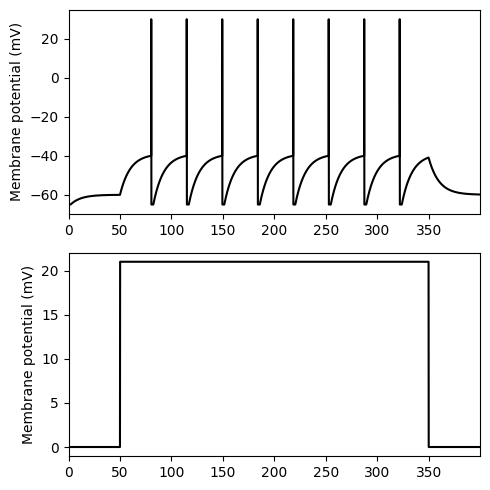

In [4]:
# 描画

plt.figure(figsize=(5, 5))
plt.subplot(2, 1, 1)
plt.plot(t, v_arr, color="k")
plt.ylabel("Membrane potential (mV)")
plt.xlim(0, t.max())

plt.subplot(2, 1, 2)
plt.plot(t, I, color="k")
plt.ylabel("Membrane potential (mV)")
plt.xlim(0, t.max())
plt.tight_layout()
plt.show()